In [1]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
filepath = r'imu_logs\arc_fast.csv'
# Load your real data
df = pd.read_csv(filepath)

# Extract needed columns
t = df.index.values*0.01                    # Time in seconds
dt = np.diff(t, prepend=t[0])      # time steps (should be ~constant, but safe)


(188, 14)
Index(['timestamp', 'AccX', 'AccY', 'AccZ', 'AngX', 'AngY', 'AngZ', 'AsX',
       'AsY', 'AsZ', 'Q0', 'Q1', 'Q2', 'Q3'],
      dtype='object')


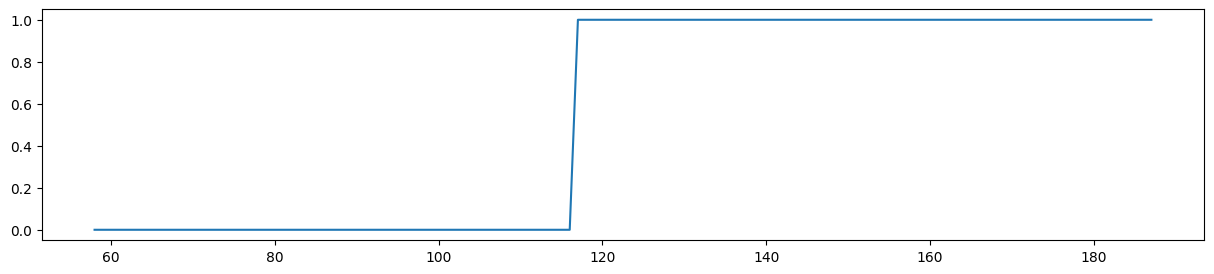

In [2]:

data = pd.read_csv(filepath)
#data.reset_index(inplace=True,drop=True)
#data.index = data.index*10/1000  #10
timestep = 1/100
print(data.shape)
print(data.columns)
data['total_acc_change']= (data[['AccX', 'AccY', 'AccZ']].diff().rolling(10).mean().sum(axis=1).abs())
data['active_period'] = (data['total_acc_change']>0.5).astype(int).rolling(10).min().rolling(50).max()#.shift(-20)
data['active_period'].plot(figsize=(15,3))
#data = data[data['active_period']==1]
df = data

In [3]:
acc = data[['AccX', 'AccY', 'AccZ']].values
rpy = data[['AngX', 'AngY', 'AngZ']].values
quat = data[['Q0','Q1','Q2','Q3']].values
n = len(acc)

# Build orientation objects
rot = R.from_euler('xyz', rpy, degrees=True)


In [4]:
# Compute acceleration magnitude
a_mag = np.linalg.norm(acc, axis=1)

In [5]:
np.mean(a_mag[0:10])

np.float64(9.625561088382355)

In [6]:
np.mean(acc[0:100],axis=0)

array([-5.34632, -0.4867 ,  7.78409])

In [7]:
# Per-sample gravity removal & world-frame accel
g_world = np.array([0,0,10.081836018871865])#9.81
acc_world = np.zeros((n, 3))
for i in range(n):
    g_body_i     = rot[i].inv().apply(g_world)
    a_dyn_body   = acc[i] - g_body_i
    acc_world[i] = rot[i].apply(a_dyn_body)
np.mean(acc_world[0:10])

np.float64(-0.15790029661727478)

In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

def compute_trajectory(df, deadband=0.1, sample_rate=100):
    """
    Computes world-frame trajectory, velocity, and acceleration magnitude 
    from raw IMU DataFrame.
    
    Parameters:
    - df: DataFrame with columns ['AccX','AccY','AccZ','AngX','AngY','AngZ']
    - deadband: threshold for |a| below which the device is considered at rest
    - sample_rate: sampling frequency in Hz
    
    Returns:
    - pos: (N,3) array of positions [m]
    - vel: (N,3) array of velocities [m/s]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    """
    # Extract raw accel and angles
    acc = df[['AccX', 'AccY', 'AccZ']].values
    rpy = df[['AngX', 'AngY', 'AngZ']].values
    n = len(acc)
    
    # Build orientation objects
    rot = R.from_euler('xyz', rpy, degrees=True)    
    # Compute acceleration magnitude
    a_mag = np.linalg.norm(acc, axis=1)    
    
    # Per-sample gravity removal & world-frame accel
    g_world = np.array([0,0,np.mean(a_mag[0:10])])#9.81
    acc_world = np.zeros((n, 3))
    for i in range(n):
        g_body_i     = rot[i].inv().apply(g_world)
        a_dyn_body   = acc[i] - g_body_i
        acc_world[i] = rot[i].apply(a_dyn_body)
    
    # Remove mean residual to zero net accel
    residual_mean = np.mean(acc_world, axis=0)
    acc_world -= residual_mean
    
    # Compute acceleration magnitude
    a_mag = np.linalg.norm(acc_world, axis=1)
    
    # Manual trapezoidal integration with deadband
    dt = 1.0 / sample_rate
    vel = np.zeros_like(acc_world)
    pos = np.zeros_like(acc_world)
    
    for i in range(1, n):
        # Integrate
        vel[i] = vel[i-1] + 0.5 * (acc_world[i] + acc_world[i-1]) * dt
        pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt
        
        # Deadband rest clamp
        if a_mag[i] < deadband:
            vel[i] = 0
            pos[i] = pos[i-1]
    
    return pos, vel, a_mag

def compute_trajectory_2(df, deadband=0.1, sample_rate=100):
    """
    Computes world-frame trajectory, velocity, and acceleration magnitude 
    from raw IMU DataFrame.
    
    Parameters:
    - df: DataFrame with columns ['AccX','AccY','AccZ','AngX','AngY','AngZ']
    - deadband: threshold for |a| below which the device is considered at rest
    - sample_rate: sampling frequency in Hz
    
    Returns:
    - pos: (N,3) array of positions [m]
    - vel: (N,3) array of velocities [m/s]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    """
    # Extract raw accel and angles
    acc = df[['AccX', 'AccY', 'AccZ']].values
    rpy = df[['AngX', 'AngY', 'AngZ']].values
    n = len(acc)
    
    # Build orientation objects
    rot = R.from_euler('xyz', rpy, degrees=True)    
    # Compute acceleration magnitude
    a_mag = np.linalg.norm(acc, axis=1)    
    
    # 1) Take your first N samples as “static”
    N_cal = 10
    acc_static = acc[:N_cal]  # raw [N_cal×3]
    rpy_static = rpy[:N_cal]
    rot_static = R.from_euler('xyz', rpy_static, degrees=True)

    # 2) Estimate g_world magnitude from the static accel magnitudes
    g_mag = np.mean(np.linalg.norm(acc_static, axis=1))
    g_world = np.array([0, 0, g_mag])

    # 3) Compute the *body‐frame* mean accel
    #    mean_acc_body = g_body_static + bias_body
    mean_acc_body = np.mean(acc_static, axis=0)

    # 4) Compute the *body‐frame* gravity direction at sample 0
    g0_body = rot_static[0].inv().apply(g_world)

    # 5) Solve for constant bias in the body frame
    bias_body = mean_acc_body - g0_body

    for i in range(n):
        # instantaneous gravity in body frame
        g_body_i   = rot[i].inv().apply(g_world)
        # subtract both gravity and bias in *body* frame
        a_dyn_body = acc[i] - g_body_i - bias_body
        # rotate into world
        acc_world[i] = rot[i].apply(a_dyn_body)
    # Compute acceleration magnitude
    a_mag = np.linalg.norm(acc_world, axis=1)
    
    # Manual trapezoidal integration with deadband
    dt = 1.0 / sample_rate
    vel = np.zeros_like(acc_world)
    pos = np.zeros_like(acc_world)
    
    for i in range(1, n):
        # Integrate
        vel[i] = vel[i-1] + 0.5 * (acc_world[i] + acc_world[i-1]) * dt
        pos[i] = pos[i-1] + 0.5 * (vel[i] + vel[i-1]) * dt
        
        # Deadband rest clamp
        if a_mag[i] < deadband:
            vel[i] = 0
            pos[i] = pos[i-1]
    
    return pos, vel, a_mag

def plot_trajectory(pos, a_mag, title='Trajectory with Deadband & |a| in Hover'):
    """
    Plots a 3D trajectory with acceleration magnitude in hover info.
    
    Parameters:
    - pos: (N,3) array of positions [m]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    - title: Figure title string
    """
    fig = go.Figure([
        go.Scatter3d(
            x=pos[:,0], y=pos[:,1], z=pos[:,2],
            mode='lines+markers',
            line=dict(color='blue', width=2),
            marker=dict(color='blue', size=2),
            name='Trajectory',
            customdata=a_mag[:, None],
            hovertemplate=(
                'X: %{x:.3f} m<br>'
                'Y: %{y:.3f} m<br>'
                'Z: %{z:.3f} m<br>'
                '|a|: %{customdata[0]:.3f} m/s²'
            )
        ),
        go.Scatter3d(
            x=[0], y=[0], z=[0],
            mode='markers',
            marker=dict(color='green', size=8),
            name='Start',
            hovertemplate='Start<br>X: 0<br>Y: 0<br>Z: 0'
        ),
        go.Scatter3d(
            x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
            mode='markers',
            marker=dict(color='red', size=8),
            name='End',
            hovertemplate=(
                'End<br>'
                'X: %{x:.3f} m<br>'
                'Y: %{y:.3f} m<br>'
                'Z: %{z:.3f} m'
            )
        )
    ])
    fig.update_layout(
        scene=dict(
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            aspectmode='data'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# Example usage:
# df = pd.read_csv('your_data.csv')
# pos, vel, a_mag = compute_trajectory(df, deadband=0.1, sample_rate=100)
# plot_trajectory(pos, a_mag)


In [9]:
pos, vel, a_mag = compute_trajectory_2(df, deadband=12, sample_rate=100)
plot_trajectory(pos, a_mag)


In [10]:
def plot_trajectory_with_dots(pos, a_mag, title='Trajectory with Dots & |a| in Hover'):
    """
    Plots a 3D trajectory with small marker dots at every data point,
    and acceleration magnitude in hover info.
    
    Parameters:
    - pos: (N,3) array of positions [m]
    - a_mag: (N,) array of acceleration magnitudes [m/s²]
    - title: Figure title
    """
    fig = go.Figure([
        go.Scatter3d(
            x=pos[:,0], y=pos[:,1], z=pos[:,2],
            mode='lines+markers',
            line=dict(color='blue', width=2),
            marker=dict(color='blue', size=2),
            name='Trajectory',
            customdata=a_mag[:, None],
            hovertemplate=(
                'X: %{x:.3f} m<br>'
                'Y: %{y:.3f} m<br>'
                'Z: %{z:.3f} m<br>'
                '|a|: %{customdata[0]:.3f} m/s²'
            )
        ),
        go.Scatter3d(
            x=[pos[0,0]], y=[pos[0,1]], z=[pos[0,2]],
            mode='markers',
            marker=dict(color='green', size=6),
            name='Start',
            hovertemplate='Start<br>X: %{x:.3f} m<br>Y: %{y:.3f} m<br>Z: %{z:.3f} m'
        ),
        go.Scatter3d(
            x=[pos[-1,0]], y=[pos[-1,1]], z=[pos[-1,2]],
            mode='markers',
            marker=dict(color='red', size=6),
            name='End',
            hovertemplate='End<br>X: %{x:.3f} m<br>Y: %{y:.3f} m<br>Z: %{z:.3f} m'
        )
    ])
    fig.update_layout(
        scene=dict(
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            aspectmode='data'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

In [11]:
plot_trajectory_with_dots(pos, a_mag,)


In [12]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

def calculate_plane_from_arc(pos, center):
    """
    Given trajectory points `pos` and a specified `center` of the arc,
    returns basis vectors and normal defining the plane of the arc.
    """
    # Vectors from center to first and last points
    a = pos[0] - center
    b = pos[-1] - center
    
    # Normal of the plane
    normal = np.cross(a, b)
    normal /= np.linalg.norm(normal)
    
    # First basis vector along a
    u = a / np.linalg.norm(a)
    # Second basis vector orthogonal to u in the plane
    v = np.cross(normal, u)
    v /= np.linalg.norm(v)
    
    return normal, u, v

def calculate_plane_from_arc_least_squares(pos):
    """
    Fit a plane to a set of 3D points `pos` using least squares (SVD).
    Returns:
      - center: the centroid of `pos`
      - normal: unit normal vector of the best-fit plane
      - u, v: two orthonormal basis vectors spanning the plane
    """
    # 1) Compute centroid
    center = np.mean(pos, axis=0)
    # 2) Shift points to centroid
    X = pos - center
    # 3) SVD: X = U S Vt
    _, _, Vt = np.linalg.svd(X, full_matrices=False)
    # Vt[0], Vt[1] span the plane; Vt[2] is normal (least variance)
    u = Vt[0] / np.linalg.norm(Vt[0])
    v = Vt[1] / np.linalg.norm(Vt[1])
    normal = Vt[2] / np.linalg.norm(Vt[2])
    return center, normal, u, v

def plot_trajectory_with_plane(pos, center, resolution=10, opacity=0.5, title="Trajectory & Plane"):
    """
    Plots 3D trajectory and the best-fit plane defined by `center` and the arc in `pos`.
    
    Parameters:
    - pos: (N,3) array of trajectory points
    - center: (3,) array of the arc's center point
    - resolution: grid resolution for plane mesh
    - opacity: transparency of the plane
    """
    # Compute plane basis
    center, normal, u, v = calculate_plane_from_arc_least_squares(pos)#calculate_plane_from_arc(pos, center)
    
    # Determine grid extents based on maximum radius
    r = np.max(np.linalg.norm(pos - center, axis=1))
    us = np.linspace(-r, r, resolution)
    vs = np.linspace(-r, r, resolution)
    uu, vv = np.meshgrid(us, vs)
    
    # Generate plane coordinates
    Xp = center[0] + uu * u[0] + vv * v[0]
    Yp = center[1] + uu * u[1] + vv * v[1]
    Zp = center[2] + uu * u[2] + vv * v[2]
    
    # Build figure
    fig = go.Figure()
    
    # Add plane
    fig.add_trace(go.Surface(
        x=Xp, y=Yp, z=Zp,
        opacity=opacity,
        showscale=False,
        name="Plane"
    ))
    
    # Add trajectory
    fig.add_trace(go.Scatter3d(
        x=pos[:,0], y=pos[:,1], z=pos[:,2],
        mode='lines+markers',
        line=dict(color='blue', width=3),
        marker=dict(size=3, opacity=0.7),
        name='Trajectory'
    ))
    
    # Add center point
    fig.add_trace(go.Scatter3d(
        x=[center[0]], y=[center[1]], z=[center[2]],
        mode='markers',
        marker=dict(color='red', size=6),
        name='Center'
    ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='X [m]',
            yaxis_title='Y [m]',
            zaxis_title='Z [m]',
            aspectmode='data'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()
    
import numpy as np

def calculate_arc_center(pos, eps=1e-6):
    """
    Estimate the center of the circular arc described by pos:
      • p1 = pos[0]
      • p2 = the apex = the point farthest from p1
      • p3 = pos[-1]
    If p1, p2, p3 are nearly collinear (denominator≈0),  
    fall back to the midpoint of p1–p3.
    """
    p1 = pos[0]
    # apex = point farthest from start
    dists = np.linalg.norm(pos - p1, axis=1)
    idx_apex = np.argmax(dists)
    p2 = pos[idx_apex]
    p3 = pos[-1]

    b = p2 - p1
    c = p3 - p1
    bc = np.cross(b, c)
    denom = 2.0 * np.dot(bc, bc)

    if abs(denom) < eps:
        # nearly collinear → use simple midpoint fallback
        return (p1 + p3) / 2.0

    b2 = np.dot(b, b)
    c2 = np.dot(c, c)
    term1 = np.cross(bc, b) * c2
    term2 = np.cross(c, bc) * b2
    center = p1 + (term1 + term2) / denom
    return center

# Example usage:
# df = pd.read_csv('your_data.csv')
# pos, vel, a_mag = compute_trajectory_2(df)
# center_point = np.array([0.0, 0.0, 0.5])  # set based on your arc geometry
# plot_trajectory_with_plane(pos, center_point)


In [13]:
# 1) compute trajectory
pos, vel, a_mag = compute_trajectory_2(df,deadband=9)

# 2) estimate center of the arc
center = calculate_arc_center(pos)

# 3) plot both trajectory and fitted plane
plot_trajectory_with_plane(pos, center, resolution=20, opacity=0.4)

In [14]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

def fit_plane_pca(points):
    """
    Fit plane via PCA: returns centroid (plane point), normal, and in-plane axes u, v.
    """
    centroid = np.mean(points, axis=0)
    X = points - centroid
    _, _, Vt = np.linalg.svd(X, full_matrices=False)
    u = Vt[0] / np.linalg.norm(Vt[0])
    v = Vt[1] / np.linalg.norm(Vt[1])
    normal = Vt[2] / np.linalg.norm(Vt[2])
    return centroid, normal, u, v

def fit_circle_2d(xy):
    """
    Algebraic 2D circle fit: solves for (cx, cy, r)
    """
    x = xy[:,0]; y = xy[:,1]
    A = np.column_stack([2*x, 2*y, np.ones_like(x)])
    b = x**2 + y**2
    c, d, f = np.linalg.lstsq(A, b, rcond=None)[0]
    cx, cy = c, d
    r = np.sqrt(f + cx**2 + cy**2)
    return np.array([cx, cy]), r

def calculate_plane_and_center_from_arc(pos):
    """
    Fit plane to trajectory, then fit a circle in that plane to find true center.
    Returns:
      - center_3d: 3D circle center
      - normal, u, v: plane axes
      - radius: circle radius
    """
    # 1) Fit plane
    centroid, normal, u, v = fit_plane_pca(pos)
    # 2) Project points to plane coords
    X = pos - centroid
    coords2d = np.vstack([X.dot(u), X.dot(v)]).T
    # 3) Fit circle in 2D
    center2d, radius = fit_circle_2d(coords2d)
    # 4) Back to 3D
    center_3d = centroid + center2d[0]*u + center2d[1]*v
    return center_3d, normal, u, v, radius

def plot_trajectory_with_fitted_plane_and_circle(pos, resolution=20, opacity=0.5, title="Trajectory + Fitted Plane"):
    """
    Plots trajectory, best-fit plane, and circle center/radius.
    """
    center, normal, u, v, radius = calculate_plane_and_center_from_arc(pos)
    # Create plane mesh
    r_lim = radius * 1.2
    us = np.linspace(-r_lim, r_lim, resolution)
    vs = np.linspace(-r_lim, r_lim, resolution)
    uu, vv = np.meshgrid(us, vs)
    Xp = center[0] + uu*u[0] + vv*v[0]
    Yp = center[1] + uu*u[1] + vv*v[1]
    Zp = center[2] + uu*u[2] + vv*v[2]

    fig = go.Figure()
    # plane
    fig.add_trace(go.Surface(x=Xp, y=Yp, z=Zp, opacity=opacity, showscale=False, name="Plane"))
    # trajectory
    fig.add_trace(go.Scatter3d(x=pos[:,0], y=pos[:,1], z=pos[:,2],
                                mode='lines+markers', line=dict(color='blue', width=3),
                                marker=dict(size=3), name='Trajectory'))
    # circle center
    fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]],
                                mode='markers', marker=dict(color='red', size=6),
                                name=f'Circle Center (r={radius:.2f})'))
    fig.update_layout(scene=dict(xaxis_title='X [m]', yaxis_title='Y [m]', zaxis_title='Z [m]', aspectmode='data'),
                      title=title, margin=dict(l=0,r=0,b=0,t=30))
    fig.show()

# Example usage:
pos, vel, a_mag = compute_trajectory_2(df,deadband=12)
plot_trajectory_with_fitted_plane_and_circle(pos)